# **THESEUS**
## **INFERENCE**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# **CONFIGURATION**

In [2]:
ROOT            = "/kaggle/input/home-credit-credit-risk-model-stability"

In [3]:

CONFIG_LIBRARY={

    1 :  {    "id": 1,
    "type":"LGBMClassifier",
    "parent": 0, # 0 means metamodel
    "children": None, 
    "parameters" : {},
    "make_data_func": "make_data_for_lgb",
    "fit_func": "kfold_lgb"
    
    
},
    
    2: {
    "id": 2,
    "type":"CatBoost",
    "parent": 0,
    "children" : None,
    "parameters" : {},
    "make_data_func": "make_data_for_cat",
    "fit_func": "kfold_cat"
}
,
    0: {
    "id": 0,
    "type" : "Ensemble (LGBMClassifier, CatBoost)",
    "parent": None,
    "children" : [1,2],
    "parameters" : {},
    "make_data_func": "prepare_for_metamodel",
    "fit_func": "simple_average"
    
},
    
    
    
}
    


In [4]:
from graphviz import Digraph, Source

def visualize_ensemble_structure(config):
    dot = Digraph()

    def add_nodes_edges(node):
        if node["parent"] is None:
            dot.node(str(node["id"]), label=node["type"], shape="box")
        else:
            dot.node(str(node["id"]), label=node["type"])
        if node["children"]:
            for child_id in node["children"]:
                dot.edge(str(node["id"]), str(child_id))
                add_nodes_edges(config[child_id])

    for _, node in config.items():
        add_nodes_edges(node)

    return dot

# **INFRASTRUCTURE**

In [5]:
class VotingModel():
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        
        return np.mean(y_preds, axis=0)

In [6]:
class Model:
    def __init__ (self, init_id):
        
        if init_id==0:
            print("MODEL ", init_id, " is being initialized")
        else:
            print("\tMODEL ", init_id, " is being initialized")
        if init_id not in CONFIG_LIBRARY:
            raise ValueError("Invalid input Type - class Model initialization")
        
          
        self.definition=CONFIG_LIBRARY[init_id]    

        self.state=0 
        # 0=initialized
        # 1,  for base models: fitted; for ensembles: created oof predictions
       
        self.id=init_id
        self.model_children=[]
        
        if self.definition['children'] is not None:
            print("model ", init_id, " has children ",self.definition['children'])
            for i in self.definition['children']:
             
                if i not in CONFIG_LIBRARY:
                    raise ValueError("Invalid input Type - class Model initialization")
                
                self.model_children.append(Model(i))
                
        if init_id==0:
            print("MODEL ", init_id, " has been initialized")      
        else:
            print("\tMODEL ", init_id, " has been initialized")     
       
        
        
    def train(self):
        
        print("Function train() of model ", self.id, " has started")
        if self.model_children:
            for child in self.model_children:
                child.train()
            print("All submodels of model ", self.id, " have been trained")
        
       
        self.path_input=self.make_data()
        self.fit(self.path_input)
        self.path_output=self.make_prediction(self.path_input)
        
        
        print("Function train() of model ", self.id, " has finished")
        
    def make_data(self):
        print("Function make_data of model ", self.id, " has started")
        func = globals().get(self.definition["make_data_func"])
        if func is not None and callable(func):
            
            path=func()
        else:
            raise ValueError("Invalid input Type - make data function")
            
        
        print("Function make_data of model ", self.id, " has finished")    
        return path
    
    
    def fit(self, path):
        
        
        
        print("Fit - model ", self.id, " started, path: ", path)
        func = globals().get(self.definition["fit_func"])
        if func is not None and callable(func):
            self.estimators=[]
            #self.estimators
            self.model, self.oof_preds=func(path)
            
            
            
        else:
            raise ValueError("Invalid input Type - fit function") 

     
            
       
        print("Fit - model ", self.id, " finished")
        
        
    def make_prediction(self, path):
        
        data = pd.read_parquet(path) 
        for col in data.select_dtypes(exclude=['number','bool']).columns:
            data[col] = data[col].astype('category')
        data_target = data[['case_id', 'WEEK_NUM', 'target']].set_index('case_id')
        data.drop(data[data['target'].notnull()].index, inplace=True)
        case_ids=data['case_id'].copy()
        data.drop(columns=['case_id', 'WEEK_NUM', 'target'], inplace=True)
        print(self.model.predict_proba(data)[:,1].shape)
        y_preds=pd.Series(self.model.predict_proba(data)[:,1], index=case_ids)
        
        print(y_preds.head())
        
        #oof_preds_df=pd.DataFrame({str("model"+str(self.id)): y_preds})
        
        output = pd.DataFrame({str("preds"): y_preds})
        
        stacked_df = pd.concat([self.oof_preds, output])
        merged_df = pd.concat([data_target, stacked_df], axis=1).reset_index()
        print("oof_preds shape", self.oof_preds.shape)
        print("output shape", output.shape)
        print("stacked shape", stacked_df.shape)
        print("merged shape", merged_df.shape)
        
        
        # Print unique index values
        print("\nUnique index values in oof_preds:")
        print(self.oof_preds.index.unique())

        print("\nUnique index values in output:")
        print(output.index.unique())

        print("\nUnique index values in stacked_df:")
        print(stacked_df.index.unique())
        
        print(output.head())
        path_output=str("/kaggle/working/output"+str(self.id)+".parquet")
        merged_df.to_parquet(path_output)
        
        if self.id==0:
        
            #df_subm = pd.read_csv(str(ROOT + "/sample_submission.csv"))
            df_subm=pd.DataFrame({'case_id': case_ids, 'score': y_preds})
            df_subm = df_subm.set_index("case_id")
            df_subm.to_csv("submission.csv")
        
        return path_output
        
    
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
        
        '''
    def predict(self):
        
    
        
    def set_oof_predictions(self, series):
        
    def get_oof_predictions(self, series):
        
    def stack(self):
    '''
    


In [7]:
def prepare_for_metamodel():
    
    
    
    df1=pd.read_parquet("/kaggle/working/output1.parquet")
    df2=pd.read_parquet("/kaggle/working/output2.parquet")
    #df1.reset_index(inplace=True)
# Check if the "target" column is the same for both DataFrames based on their indexes
    print(df1)
    
    
    merged_df = df1.merge(df2, left_index=True, right_index=True, suffixes=('_df1', '_df2'))

# Drop duplicate columns for "target", "WEEK_NUM", and "case_id"
    merged_df.drop(['target_df2', 'WEEK_NUM_df2', 'case_id_df2'], axis=1, inplace=True)

    # Rename columns to remove the suffix for the second preds column
    merged_df.rename(columns={'case_id_df1':'case_id','WEEK_NUM_df1':'WEEK_NUM','target_df1': 'target', 'preds_df1': 'preds0','preds_df2': 'preds1'}, inplace=True)

    # Print the merged DataFrame
    print(merged_df)
    
    merged_df.to_parquet("/kaggle/working/input0.parquet")
    
    return "/kaggle/working/input0.parquet"

In [8]:
prepare_for_metamodel()

     case_id  WEEK_NUM  target     preds
0          0        18     0.0  0.055205
1          1         9     1.0  0.995905
2          2         4     1.0  0.628870
3          3        33     1.0  0.997513
4          4        47     NaN  0.014701
..       ...       ...     ...       ...
886      886         9     NaN  0.088902
887      887        38     1.0  0.997204
888      888        27     0.0  0.193198
889      889        34     1.0  0.509808
890      890        28     0.0  0.056984

[891 rows x 4 columns]
     case_id  WEEK_NUM  target    preds0    preds1
0          0        18     0.0  0.055205  0.090304
1          1         9     1.0  0.995905  0.933729
2          2         4     1.0  0.628870  0.563663
3          3        33     1.0  0.997513  0.954356
4          4        47     NaN  0.014701  0.115530
..       ...       ...     ...       ...       ...
886      886         9     NaN  0.088902  0.120708
887      887        38     1.0  0.997204  0.954369
888      888        27   

'/kaggle/working/input0.parquet'

In [9]:
def simple_average(path):
    
    
    class Average:
        def __init__(self):
            super().__init__()
        #self.estimators = estimators
        
        
        def fit(self, X, y=None):
            return self

        def predict(self, X):
            # Check if X is a pandas DataFrame with 2 numerical columns
            if not isinstance(X, pd.DataFrame):
                raise ValueError("X must be a pandas DataFrame")
            if len(X.columns) != 2:
                raise ValueError("X must have exactly 2 columns")
            if not all(X.dtypes == 'int64') and not all(X.dtypes == 'float64'):
                raise ValueError("Both columns in X must be numerical")

            # Calculate the mean of each column
            result = X.mean(axis=1)

            # Convert the result to a pandas Series with discrete values (0 or 1)
            result = (result >= 0.5).astype(int)

            return result

        def predict_proba(self, X):
            # Check if X is a pandas DataFrame with 2 numerical columns
            if not isinstance(X, pd.DataFrame):
                raise ValueError("X must be a pandas DataFrame")
            if len(X.columns) != 2:
                raise ValueError("X must have exactly 2 columns")
            if not all(X.dtypes == 'int64') and not all(X.dtypes == 'float64'):
                raise ValueError("Both columns in X must be numerical")

            # Calculate the mean of each column
            result = X.mean(axis=1)

            # Convert the result to a pandas Series
            result1 = pd.Series(result)
            result0= 1 - pd.Series(result)

            return pd.DataFrame({'0': result0, '1': result1}).values
        
    model=Average()
    
    data=pd.read_parquet("/kaggle/working/input0.parquet")
    

    
    data.drop(data[data['target'].isnull()].index, inplace=True)
    target=data['target'].copy()
    
    data.drop(columns=['target','WEEK_NUM'], inplace=True)
    
    print(data)
    oof_preds=model.predict_proba(data.drop(columns=['case_id']))[:,1]
    
    print('Full AUC score %.6f' % roc_auc_score(target, oof_preds))
    plt.figure(figsize=(8, 6))
    plt.hist(oof_preds, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Prediction Probability Histogram')
    plt.grid(True)
    plt.show()
        
    return model, pd.DataFrame({'preds': pd.Series(oof_preds, index=data['case_id'])})

In [10]:
result = [0.2, 0.5, 0.8]

# Create result1 and result0 Series based on result
result1 = pd.Series(result)
result0 = 1 - pd.Series(result)

# Print the Series
print("result1:", result1)
print("result0:", result0)

result1: 0    0.2
1    0.5
2    0.8
dtype: float64
result0: 0    0.8
1    0.5
2    0.2
dtype: float64


In [11]:
data = {
    'column1': [1, 2, 3, 4, 5],
    'column2': [6, 7, 8, 9, 10]
}

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data)

     case_id    preds0    preds1
0          0  0.055205  0.090304
1          1  0.995905  0.933729
2          2  0.628870  0.563663
3          3  0.997513  0.954356
5          5  0.009285  0.063371
..       ...       ...       ...
885      885  0.051870  0.273850
887      887  0.997204  0.954369
888      888  0.193198  0.408417
889      889  0.509808  0.295840
890      890  0.056984  0.062793

[802 rows x 3 columns]
Full AUC score 0.872715


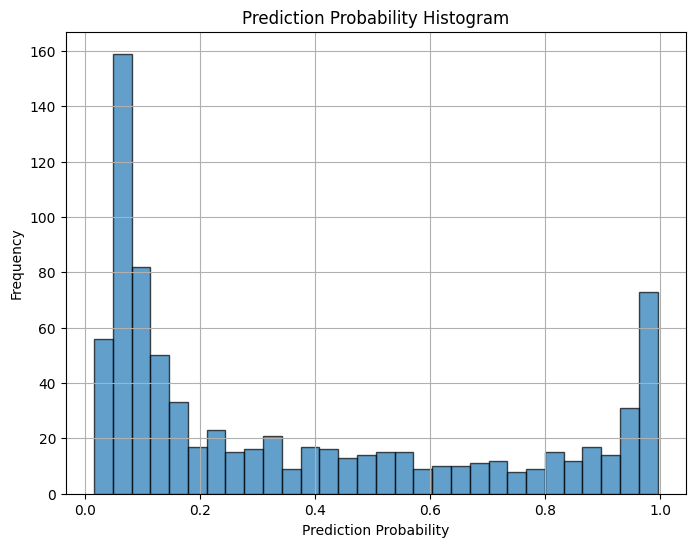

array([[-2.5,  3.5],
       [-3.5,  4.5],
       [-4.5,  5.5],
       [-5.5,  6.5],
       [-6.5,  7.5]])

In [12]:
model, oof_preds=simple_average("abc")
model.predict_proba(df)

In [13]:
oof_preds

,preds
case_id,
0,0.072755
1,0.964817
2,0.596267
3,0.975935
5,0.036328
...,...
885,0.162860
887,0.975786
888,0.300808


In [14]:
def initialization():
    
    print("Function initialization has been started")
    if not check_validity():
        raise ValueError("Invalid input Type - model configuration")
    metamodel=Model(0)
   
    print("Function initialization has been successful")
    print()
 
    return metamodel

In [15]:
def kfold_lgb(path):
    
    data=pd.read_parquet(path)
    data.drop(data[data['target'].isnull()].index, inplace=True)
    print(data.dtypes.value_counts())
    
        
        
    folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state= 42)
    fitted_models=[]
    oof_preds = np.zeros(data.shape[0])
    eval_results = dict()
    with tqdm(total=5) as pbar:
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(np.zeros(len(data)), data['target'])):
            train_data = data.iloc[train_idx]
            valid_data = data.iloc[valid_idx]
            clf = LGBMClassifier()  # Create LGBMClassifier model
            clf.fit(train_data.drop(columns=['target','WEEK_NUM','case_id'], axis=1), train_data['target'])  # Fit the model
            fitted_models.append(clf)
            oof_preds[valid_idx]=clf.predict_proba(valid_data.drop(columns=['target','WEEK_NUM','case_id'], axis=1))[:,1]
            # Append the model to the list of fitted models
            pbar.update(1)
    print('Full AUC score %.6f' % roc_auc_score(data['target'], oof_preds))
    print("Confusion Matrix for Full Dataset:")
    print(confusion_matrix(data['target'], (oof_preds > 0.5).astype(int)))
    
    # Plot prediction probability histogram
    plt.figure(figsize=(8, 6))
    plt.hist(oof_preds, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Prediction Probability Histogram')
    plt.grid(True)
    plt.show()
    model=VotingModel(fitted_models)
    return model, pd.DataFrame({'preds': pd.Series(oof_preds, index=data['case_id'])})

In [16]:
def kfold_cat(path):
    data = pd.read_parquet(path)
    data.drop(data[data['target'].isnull()].index, inplace=True)
    print(data.dtypes.value_counts())
    
    
        
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fitted_models = []
    oof_preds = np.zeros(data.shape[0])
    eval_results = dict()
    
    with tqdm(total=5) as pbar:
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(np.zeros(len(data)), data['target'])):
            train_data = data.iloc[train_idx]
            valid_data = data.iloc[valid_idx]
            
            clf = CatBoostClassifier(iterations=1000,  # Specify the number of iterations
                                     learning_rate=0.1,  # Specify the learning rate
                                     depth=6,  # Specify the depth of the trees
                                     loss_function='Logloss',  # Specify the loss function
                                     verbose=100)  # Set verbose to print training progress
                                     
            clf.fit(train_data.drop(columns=['target', 'case_id','WEEK_NUM'], axis=1),  # Train the model
                    train_data['target'],
                    eval_set=(valid_data.drop(columns=['target','case_id','WEEK_NUM'], axis=1), valid_data['target']),
                    verbose_eval=100)  # Set verbose to print evaluation progress
            
            fitted_models.append(clf)
            oof_preds[valid_idx] = clf.predict_proba(valid_data.drop(columns=['target','case_id','WEEK_NUM'], axis=1))[:, 1]
            pbar.update(1)
    
    print('Full AUC score %.6f' % roc_auc_score(data['target'], oof_preds))
    print("Confusion Matrix for Full Dataset:")
    print(confusion_matrix(data['target'], (oof_preds > 0.5).astype(int)))
    
    # Plot prediction probability histogram
    plt.figure(figsize=(8, 6))
    plt.hist(oof_preds, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Prediction Probability Histogram')
    plt.grid(True)
    plt.show()
    
    model = VotingModel(fitted_models)  # Assuming VotingModel is defined elsewhere
    return model, pd.DataFrame({'preds': pd.Series(oof_preds, index=data['case_id'])})

In [17]:
def make_data_for_cat():
    return str("/kaggle/working/input1.parquet")

In [18]:

def make_data_for_lgb():
    print("make_data_for_lgb started")
    # Load the Titanic dataset
    titanic_df = sns.load_dataset('titanic')

    titanic_df = pd.get_dummies(titanic_df, columns=['sex', 'embarked', 'class', 'who', 'deck', 'embark_town', 'alone'])
    titanic_df.drop(columns=['alive'], inplace=True)
    # Fill NaN values
    titanic_df.fillna(method='ffill', inplace=True)  # Forward fill NaN values

    titanic_df.rename(columns={'survived': 'target'}, inplace=True)
    
    # Add "case_id" column for every row
    titanic_df = titanic_df.assign(case_id=np.arange(len(titanic_df)))
    
    # Randomly select 10% of rows and set their "target" values to NaN
    n_rows = titanic_df.shape[0]
    n_nan_rows = int(0.1 * n_rows)  # 10% of rows
    nan_indices = np.random.choice(titanic_df.index, size=n_nan_rows, replace=False)
    titanic_df.loc[nan_indices, 'target'] = np.nan
    
    # Add WEEK_NUM column with random values
    titanic_df['WEEK_NUM'] = np.random.randint(0, 52, size=titanic_df.shape[0])
    
    # Check if 'case_id' column exists and print unique values and range
    if 'case_id' in titanic_df.columns:
        print("case_id column exists")
        if titanic_df['case_id'].is_unique:
            print("All values of case_id are unique")
        else:
            print("Values of case_id are not unique")
        print("Range of values of case_id:", titanic_df['case_id'].min(), "to", titanic_df['case_id'].max())
    else:
        print("case_id column does not exist")
    
    # Check if 'target' column exists and its values are 0, 1, or NaN, and count each
    if 'target' in titanic_df.columns:
        print("\ntarget column exists")
        print("Value counts of target column:")
        print(titanic_df['target'].value_counts(dropna=False))
    else:
        print("\ntarget column does not exist")
    
    # Check the range of values in the 'WEEK_NUM' column
    if 'WEEK_NUM' in titanic_df.columns:
        print("\nWEEK_NUM column exists")
        print("Range of values of WEEK_NUM:", titanic_df['WEEK_NUM'].min(), "to", titanic_df['WEEK_NUM'].max())
    else:
        print("\nWEEK_NUM column does not exist")
    
    # Calculate the percentage of NaN values in the DataFrame excluding 'target', 'case_id', and 'WEEK_NUM' columns
    nan_percentage = (titanic_df.drop(columns=['target', 'case_id', 'WEEK_NUM']).isna().sum().sum() / 
                      (titanic_df.shape[0] * (titanic_df.shape[1] - 3))) * 100
    print("\nPercentage of NaN values in DataFrame (excluding target, case_id, WEEK_NUM): {:.2f}%".format(nan_percentage))

    path = "/kaggle/working/input1.parquet"
    # Export DataFrame to Parquet
    titanic_df.to_parquet(path)
    
    print("\nmake_data_for_lgb finished")
    return path

make_data_for_lgb()


make_data_for_lgb started
case_id column exists
All values of case_id are unique
Range of values of case_id: 0 to 890

target column exists
Value counts of target column:
target
0.0    498
1.0    304
NaN     89
Name: count, dtype: int64

WEEK_NUM column exists
Range of values of WEEK_NUM: 0 to 51

Percentage of NaN values in DataFrame (excluding target, case_id, WEEK_NUM): 0.00%

make_data_for_lgb finished


/tmp/ipykernel_585/399595679.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  titanic_df.fillna(method='ffill', inplace=True)  # Forward fill NaN values


'/kaggle/working/input1.parquet'

In [19]:
def check_validity():
    
    if not(all(isinstance(key, int) for key in CONFIG_LIBRARY.keys()) and \
       len(CONFIG_LIBRARY.keys()) == len(set(CONFIG_LIBRARY.keys())) and \
       all(isinstance(value, dict) for value in CONFIG_LIBRARY.values())):
        # Your code here if all conditions are met
  
        return False
    
    
    required_keys = {
    "id", "type", "parent", "children", "parameters", "make_data_func", "fit_func"
}
    

    
    for library in CONFIG_LIBRARY.values():
        if not required_keys.issubset(library.keys()):
        
            return False
        
        
        if  not isinstance(library["id"], int):
            #print("The value associated with the key 'id' is an integer.")
       
            print("The value associated with the key 'id' is either missing or not an integer.")
            return False
        
        if  not isinstance(library["id"], int):
            #print("The value associated with the key 'id' is an integer.")
       
            print("The value associated with the key 'id' is either missing or not an integer.")
            return False
        
        if  not isinstance(library["type"], str):
            #print("The value associated with the key 'id' is an integer.")
        
            print("The value associated with the key 'type' is either missing or not an integer.")
            return False
        

    
    
    return True

In [20]:
def generate_submission_file(metamodel):
    
    metamodel.make_prediction()
    
    y_preds=metamodel.predict_proba(test_ids)
    

In [21]:
def fit_models(metamodel):
    
    print("Function fit_models has been started")
    
    metamodel.train()
    
    
    
   
    
    # iterate through children
    
    
    
    
  

In [22]:
def main(debug=False):
    
    metamodel=initialization()
    # Creates dummy version of the models.
    
    metamodel=fit_models(metamodel)
    # It trains models, it goes from apex down to the base models.
    # It creates oof predictions.
    
    #metamodel=ensemble_models(metamodel)
    
    #It sets the blending technique/
    # Now, predict_proba in metamodel is ready to be called.
    
    
    

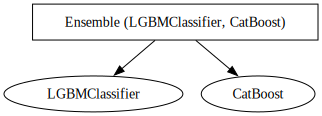

In [23]:
visualize_ensemble_structure(CONFIG_LIBRARY)

Function initialization has been started
MODEL  0  is being initialized
model  0  has children  [1, 2]
	MODEL  1  is being initialized
	MODEL  1  has been initialized
	MODEL  2  is being initialized
	MODEL  2  has been initialized
MODEL  0  has been initialized
Function initialization has been successful

Function fit_models has been started
Function train() of model  0  has started
Function train() of model  1  has started
Function make_data of model  1  has started
make_data_for_lgb started
case_id column exists
All values of case_id are unique
Range of values of case_id: 0 to 890

target column exists
Value counts of target column:
target
0.0    495
1.0    307
NaN     89
Name: count, dtype: int64

WEEK_NUM column exists
Range of values of WEEK_NUM: 0 to 51

Percentage of NaN values in DataFrame (excluding target, case_id, WEEK_NUM): 0.00%


/tmp/ipykernel_585/399595679.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  titanic_df.fillna(method='ffill', inplace=True)  # Forward fill NaN values



make_data_for_lgb finished
Function make_data of model  1  has finished
Fit - model  1  started, path:  /kaggle/working/input1.parquet
bool       24
int64       5
float64     3
Name: count, dtype: int64


  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 245, number of negative: 396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 641, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382215 -> initscore=-0.480156
[LightGBM] [Info] Start training from score -0.480156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

 20%|██        | 1/5 [00:00<00:02,  1.93it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 60%|██████    | 3/5 [00:00<00:00,  5.73it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

100%|██████████| 5/5 [00:00<00:00,  6.78it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

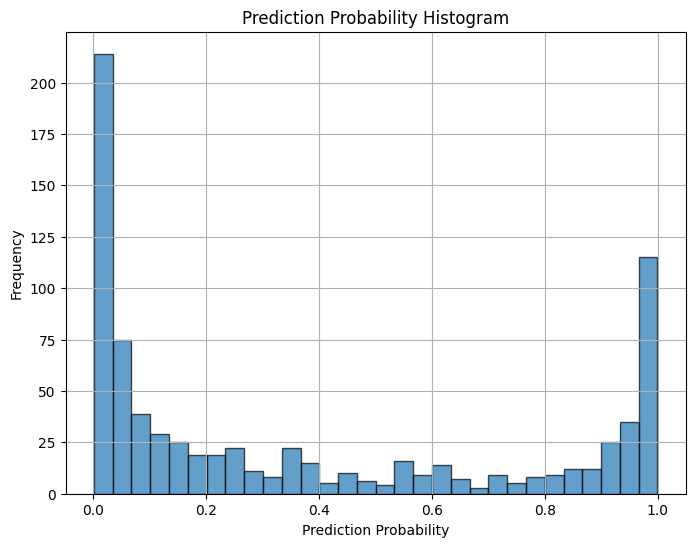

Fit - model  1  finished
(89,)
case_id
25    0.056795
28    0.910042
29    0.020520
38    0.366004
50    0.013795
dtype: float64
oof_preds shape (802, 1)
output shape (89, 1)
stacked shape (891, 1)
merged shape (891, 4)

Unique index values in oof_preds:
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       881, 882, 883, 884, 885, 886, 887, 888, 889, 890],
      dtype='int64', name='case_id', length=802)

Unique index values in output:
Index([ 25,  28,  29,  38,  50,  61,  67,  85,  92, 114, 117, 125, 127, 134,
       139, 149, 157, 158, 161, 172, 173, 182, 186, 187, 204, 240, 243, 252,
       258, 261, 270, 288, 304, 306, 309, 314, 316, 334, 347, 368, 402, 406,
       413, 415, 416, 417, 423, 437, 450, 466, 478, 484, 485, 489, 491, 493,
       502, 522, 530, 537, 541, 558, 562, 567, 593, 606, 613, 614, 625, 626,
       642, 664, 666, 698, 704, 716, 729, 730, 744, 745, 754, 760, 770, 777,
       807, 818, 830, 854, 872],
      dtype='int64', name='case_id')

Uniqu

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 0.6242459	test: 0.6445546	best: 0.6445546 (0)	total: 49.8ms	remaining: 49.7s
100:	learn: 0.2159239	test: 0.5155926	best: 0.4914221 (13)	total: 231ms	remaining: 2.05s
200:	learn: 0.1366402	test: 0.5554983	best: 0.4914221 (13)	total: 438ms	remaining: 1.74s
300:	learn: 0.0983079	test: 0.5937328	best: 0.4914221 (13)	total: 657ms	remaining: 1.52s
400:	learn: 0.0728172	test: 0.6244984	best: 0.4914221 (13)	total: 855ms	remaining: 1.28s
500:	learn: 0.0586328	test: 0.6526065	best: 0.4914221 (13)	total: 1.06s	remaining: 1.05s
600:	learn: 0.0498278	test: 0.6841358	best: 0.4914221 (13)	total: 1.26s	remaining: 838ms
700:	learn: 0.0427560	test: 0.7252746	best: 0.4914221 (13)	total: 1.47s	remaining: 626ms
800:	learn: 0.0384051	test: 0.7456847	best: 0.4914221 (13)	total: 1.68s	remaining: 418ms
900:	learn: 0.0356279	test: 0.7595597	best: 0.4914221 (13)	total: 1.92s	remaining: 211ms


 20%|██        | 1/5 [00:02<00:09,  2.34s/it]

999:	learn: 0.0331996	test: 0.7783435	best: 0.4914221 (13)	total: 2.13s	remaining: 0us

bestTest = 0.4914220621
bestIteration = 13

Shrink model to first 14 iterations.
0:	learn: 0.6342746	test: 0.6335765	best: 0.6335765 (0)	total: 2.35ms	remaining: 2.35s
100:	learn: 0.2650245	test: 0.3175685	best: 0.3172722 (97)	total: 170ms	remaining: 1.51s
200:	learn: 0.1792382	test: 0.3215253	best: 0.3160194 (121)	total: 380ms	remaining: 1.51s
300:	learn: 0.1302602	test: 0.3221873	best: 0.3160194 (121)	total: 593ms	remaining: 1.38s
400:	learn: 0.1004826	test: 0.3366748	best: 0.3160194 (121)	total: 766ms	remaining: 1.14s
500:	learn: 0.0812129	test: 0.3429083	best: 0.3160194 (121)	total: 960ms	remaining: 956ms
600:	learn: 0.0706318	test: 0.3486063	best: 0.3160194 (121)	total: 1.13s	remaining: 753ms
700:	learn: 0.0615669	test: 0.3567409	best: 0.3160194 (121)	total: 1.34s	remaining: 571ms
800:	learn: 0.0544131	test: 0.3619999	best: 0.3160194 (121)	total: 1.53s	remaining: 379ms
900:	learn: 0.0495170	tes

 40%|████      | 2/5 [00:04<00:06,  2.22s/it]

999:	learn: 0.0463263	test: 0.3768839	best: 0.3160194 (121)	total: 1.93s	remaining: 0us

bestTest = 0.3160193973
bestIteration = 121

Shrink model to first 122 iterations.
0:	learn: 0.6320922	test: 0.6323972	best: 0.6323972 (0)	total: 2.21ms	remaining: 2.2s
100:	learn: 0.2290809	test: 0.4009728	best: 0.3806264 (45)	total: 182ms	remaining: 1.62s
200:	learn: 0.1525660	test: 0.4199308	best: 0.3806264 (45)	total: 404ms	remaining: 1.6s
300:	learn: 0.1034002	test: 0.4433700	best: 0.3806264 (45)	total: 613ms	remaining: 1.42s
400:	learn: 0.0744185	test: 0.4761233	best: 0.3806264 (45)	total: 819ms	remaining: 1.22s
500:	learn: 0.0575167	test: 0.5103980	best: 0.3806264 (45)	total: 1.03s	remaining: 1.03s
600:	learn: 0.0476159	test: 0.5359426	best: 0.3806264 (45)	total: 1.25s	remaining: 827ms
700:	learn: 0.0408779	test: 0.5574989	best: 0.3806264 (45)	total: 1.43s	remaining: 610ms
800:	learn: 0.0357940	test: 0.5813590	best: 0.3806264 (45)	total: 1.62s	remaining: 404ms
900:	learn: 0.0321554	test: 0.5

 60%|██████    | 3/5 [00:06<00:04,  2.21s/it]

999:	learn: 0.0295928	test: 0.6137647	best: 0.3806264 (45)	total: 1.98s	remaining: 0us

bestTest = 0.3806264232
bestIteration = 45

Shrink model to first 46 iterations.
0:	learn: 0.6367397	test: 0.6290784	best: 0.6290784 (0)	total: 2.25ms	remaining: 2.25s
100:	learn: 0.2541889	test: 0.3411356	best: 0.3371076 (52)	total: 199ms	remaining: 1.77s
200:	learn: 0.1638864	test: 0.3585588	best: 0.3371076 (52)	total: 379ms	remaining: 1.51s
300:	learn: 0.1171613	test: 0.3639960	best: 0.3371076 (52)	total: 565ms	remaining: 1.31s
400:	learn: 0.0907986	test: 0.3757035	best: 0.3371076 (52)	total: 778ms	remaining: 1.16s
500:	learn: 0.0726128	test: 0.3899912	best: 0.3371076 (52)	total: 1s	remaining: 999ms
600:	learn: 0.0599389	test: 0.4038842	best: 0.3371076 (52)	total: 1.24s	remaining: 821ms
700:	learn: 0.0512895	test: 0.4233861	best: 0.3371076 (52)	total: 1.45s	remaining: 620ms
800:	learn: 0.0448439	test: 0.4353203	best: 0.3371076 (52)	total: 1.67s	remaining: 415ms
900:	learn: 0.0404743	test: 0.44874

 80%|████████  | 4/5 [00:09<00:02,  2.26s/it]

999:	learn: 0.0367642	test: 0.4610343	best: 0.3371076 (52)	total: 2.09s	remaining: 0us

bestTest = 0.3371075643
bestIteration = 52

Shrink model to first 53 iterations.
0:	learn: 0.6291242	test: 0.6337388	best: 0.6337388 (0)	total: 2.85ms	remaining: 2.85s
100:	learn: 0.2062390	test: 0.4969051	best: 0.4485836 (16)	total: 194ms	remaining: 1.73s
200:	learn: 0.1254441	test: 0.5492829	best: 0.4485836 (16)	total: 405ms	remaining: 1.61s
300:	learn: 0.0872892	test: 0.5969427	best: 0.4485836 (16)	total: 619ms	remaining: 1.44s
400:	learn: 0.0681259	test: 0.6313794	best: 0.4485836 (16)	total: 843ms	remaining: 1.26s
500:	learn: 0.0547453	test: 0.6655855	best: 0.4485836 (16)	total: 1.05s	remaining: 1.05s
600:	learn: 0.0470676	test: 0.6943669	best: 0.4485836 (16)	total: 1.27s	remaining: 841ms
700:	learn: 0.0407121	test: 0.7223239	best: 0.4485836 (16)	total: 1.47s	remaining: 629ms
800:	learn: 0.0364269	test: 0.7455761	best: 0.4485836 (16)	total: 1.69s	remaining: 420ms
900:	learn: 0.0329177	test: 0.76

100%|██████████| 5/5 [00:11<00:00,  2.28s/it]

999:	learn: 0.0305346	test: 0.7854148	best: 0.4485836 (16)	total: 2.15s	remaining: 0us

bestTest = 0.4485835713
bestIteration = 16

Shrink model to first 17 iterations.
Full AUC score 0.885375
Confusion Matrix for Full Dataset:
[[448  47]
 [ 95 212]]


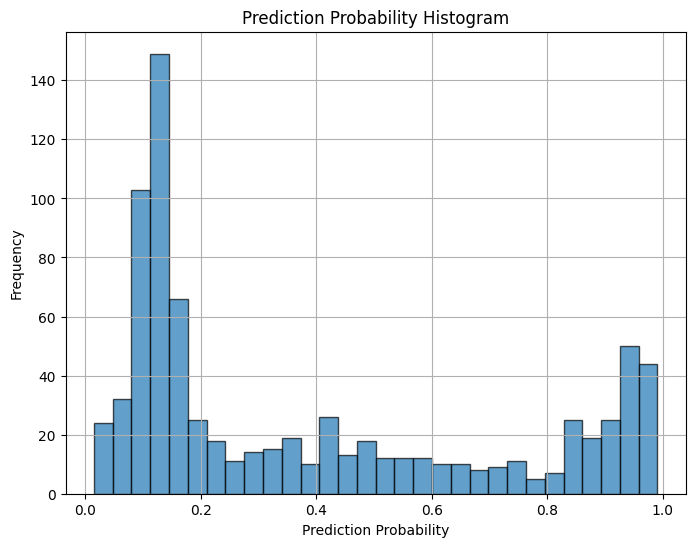

Fit - model  2  finished
(89,)
case_id
25    0.135379
28    0.712273
29    0.102391
38    0.415801
50    0.081355
dtype: float64
oof_preds shape (802, 1)
output shape (89, 1)
stacked shape (891, 1)
merged shape (891, 4)

Unique index values in oof_preds:
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       881, 882, 883, 884, 885, 886, 887, 888, 889, 890],
      dtype='int64', name='case_id', length=802)

Unique index values in output:
Index([ 25,  28,  29,  38,  50,  61,  67,  85,  92, 114, 117, 125, 127, 134,
       139, 149, 157, 158, 161, 172, 173, 182, 186, 187, 204, 240, 243, 252,
       258, 261, 270, 288, 304, 306, 309, 314, 316, 334, 347, 368, 402, 406,
       413, 415, 416, 417, 423, 437, 450, 466, 478, 484, 485, 489, 491, 493,
       502, 522, 530, 537, 541, 558, 562, 567, 593, 606, 613, 614, 625, 626,
       642, 664, 666, 698, 704, 716, 729, 730, 744, 745, 754, 760, 770, 777,
       807, 818, 830, 854, 872],
      dtype='int64', name='case_id')

Uniqu

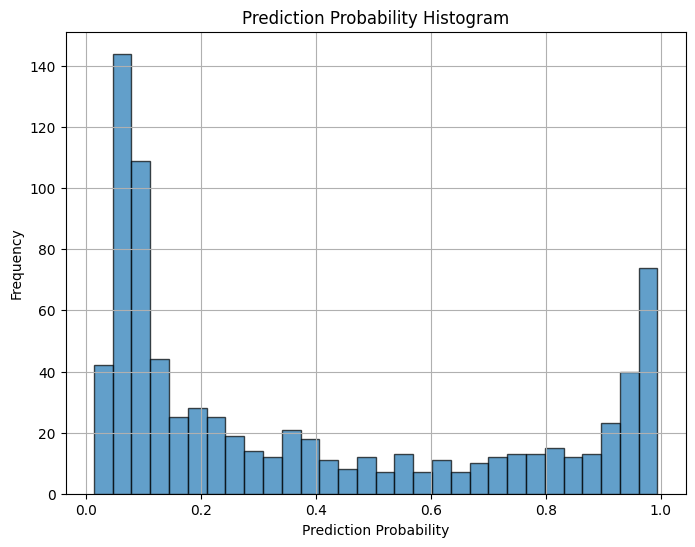

Fit - model  0  finished
(89,)
case_id
25    0.096087
28    0.811157
29    0.061455
38    0.390902
50    0.047575
dtype: float64
oof_preds shape (802, 1)
output shape (89, 1)
stacked shape (891, 1)
merged shape (891, 4)

Unique index values in oof_preds:
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       881, 882, 883, 884, 885, 886, 887, 888, 889, 890],
      dtype='int64', name='case_id', length=802)

Unique index values in output:
Index([ 25,  28,  29,  38,  50,  61,  67,  85,  92, 114, 117, 125, 127, 134,
       139, 149, 157, 158, 161, 172, 173, 182, 186, 187, 204, 240, 243, 252,
       258, 261, 270, 288, 304, 306, 309, 314, 316, 334, 347, 368, 402, 406,
       413, 415, 416, 417, 423, 437, 450, 466, 478, 484, 485, 489, 491, 493,
       502, 522, 530, 537, 541, 558, 562, 567, 593, 606, 613, 614, 625, 626,
       642, 664, 666, 698, 704, 716, 729, 730, 744, 745, 754, 760, 770, 777,
       807, 818, 830, 854, 872],
      dtype='int64', name='case_id')

Uniqu

In [24]:
main()